In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("O3 Concentration Inversion Model - Satellite Remote Sensing")
print("=" * 60)

O3 Concentration Inversion Model - Satellite Remote Sensing


In [2]:
# Cell 2: Data Loading and Basic Information
print("1. Data Loading and Preprocessing...")

# Load CSV file
df = pd.read_csv('20220101.csv')
print(f"Original data shape: {df.shape}")

# Display basic information
print(f"Column names: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

# Check missing values
print(f"\nMissing values:")
missing_info = df.isnull().sum()
for col, missing in missing_info.items():
    if missing > 0:
        print(f"  {col}: {missing} missing values ({missing/len(df)*100:.1f}%)")
    
if missing_info.sum() == 0:
    print("  No missing values found!")

1. Data Loading and Preprocessing...
Original data shape: (967, 17)
Column names: ['NAME', 'Month', 'Longitude', 'Latitude', 'O3', 'B1', 'B6', 'SAA', 'SAZ', 'SOA', 'SOZ', '边界层高(PBLH)', '相对湿度(RH)', '气压(PRES)', '大气温度(TMP)', '水平风速(U-GRD)', '垂直风速(V-GRD)']
Data types:
NAME            object
Month          float64
Longitude      float64
Latitude       float64
O3             float64
B1             float64
B6             float64
SAA            float64
SAZ            float64
SOA            float64
SOZ            float64
边界层高(PBLH)     float64
相对湿度(RH)       float64
气压(PRES)       float64
大气温度(TMP)      float64
水平风速(U-GRD)    float64
垂直风速(V-GRD)    float64
dtype: object

Missing values:
  No missing values found!


In [4]:
# Cell 3: Data Cleaning and Target Variable Analysis
# Clean data by removing rows with missing values
df_clean = df.dropna()
print(f"After cleaning data shape: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows with missing values")

# Analyze O3 distribution
print(f"\nO3 Concentration Statistics:")
o3_values = df_clean['O3'].values
print(f"  Sample size: {len(o3_values)}")
print(f"  Mean: {np.mean(o3_values):.2f} μg/m³")
print(f"  Std: {np.std(o3_values):.2f} μg/m³")
print(f"  Min: {np.min(o3_values):.2f} μg/m³")
print(f"  Max: {np.max(o3_values):.2f} μg/m³")
print(f"  Median: {np.median(o3_values):.2f} μg/m³")

# Display first few rows
print(f"\nFirst 5 rows of cleaned data:")
print(df_clean.head())

After cleaning data shape: (967, 17)
Removed 0 rows with missing values

O3 Concentration Statistics:
  Sample size: 967
  Mean: 27.06 μg/m³
  Std: 25.56 μg/m³
  Min: 1.00 μg/m³
  Max: 133.00 μg/m³
  Median: 17.00 μg/m³

First 5 rows of cleaned data:
    NAME  Month  Longitude  Latitude    O3      B1      B6      SAA     SAZ  \
0  1003A    1.0    116.434   39.9522   2.0  0.0703  0.0357  144.966  52.594   
1  1004A    1.0    116.434   39.8745   2.0  0.0818  0.0388  144.911  52.504   
2  1005A    1.0    116.473   39.9716   2.0  0.0731  0.0392  145.031  52.570   
3  1010A    1.0    116.230   40.1952  10.0  0.0729  0.0490  144.829  52.872   
4  1011A    1.0    116.407   40.0031   6.0  0.0738  0.0387  144.995  52.640   

     SOA     SOZ  边界层高(PBLH)  相对湿度(RH)     气压(PRES)  大气温度(TMP)  水平风速(U-GRD)  \
0  2.879  74.151   1324.3812   87.0760  100109.4457   274.1768     -17.1175   
1  2.880  74.072   1307.4132   87.9260  100058.2608   274.0854     -17.1560   
2  2.921  74.152   1319.9451   87.130

In [6]:
# Cell 4: Feature Selection and Data Preparation
print("2. Feature Selection and Target Variable Definition...")

# Define target variable
y = df_clean['O3'].values

# Automatically select feature variables (exclude specified columns)
exclude_cols = ['O3', 'NAME', 'Longitude', 'Latitude', 'Month']
feature_cols = [col for col in df_clean.columns 
                if col not in exclude_cols and df_clean[col].dtype in ['int64', 'float64']]
X = df_clean[feature_cols].values

print(f"Target variable (O3) shape: {y.shape}")
print(f"Feature variables: {feature_cols}")
print(f"Feature matrix shape: {X.shape}")

# Display feature statistics
print(f"\nFeature Statistics:")
feature_stats = df_clean[feature_cols].describe()
print(feature_stats.round(3))

2. Feature Selection and Target Variable Definition...
Target variable (O3) shape: (967,)
Feature variables: ['B1', 'B6', 'SAA', 'SAZ', 'SOA', 'SOZ', '边界层高(PBLH)', '相对湿度(RH)', '气压(PRES)', '大气温度(TMP)', '水平风速(U-GRD)', '垂直风速(V-GRD)']
Feature matrix shape: (967, 12)

Feature Statistics:
            B1       B6      SAA      SAZ      SOA      SOZ  边界层高(PBLH)  \
count  967.000  967.000  967.000  967.000  967.000  967.000     967.000   
mean     0.062    0.035  136.506   49.793    1.195   69.413     586.887   
std      0.031    0.020   11.017    6.020   15.110    4.862     353.769   
min      0.006    0.000  106.890   38.150  -29.704   57.557      60.638   
25%      0.032    0.016  127.936   45.838   -3.193   66.256     336.295   
50%      0.071    0.037  136.794   50.575    0.891   69.413     452.820   
75%      0.088    0.051  143.352   52.742    4.173   72.582     772.143   
max      0.120    0.102  167.046   76.976   52.149   82.962    1680.094   

       相对湿度(RH)    气压(PRES)  大气温度(TMP)  

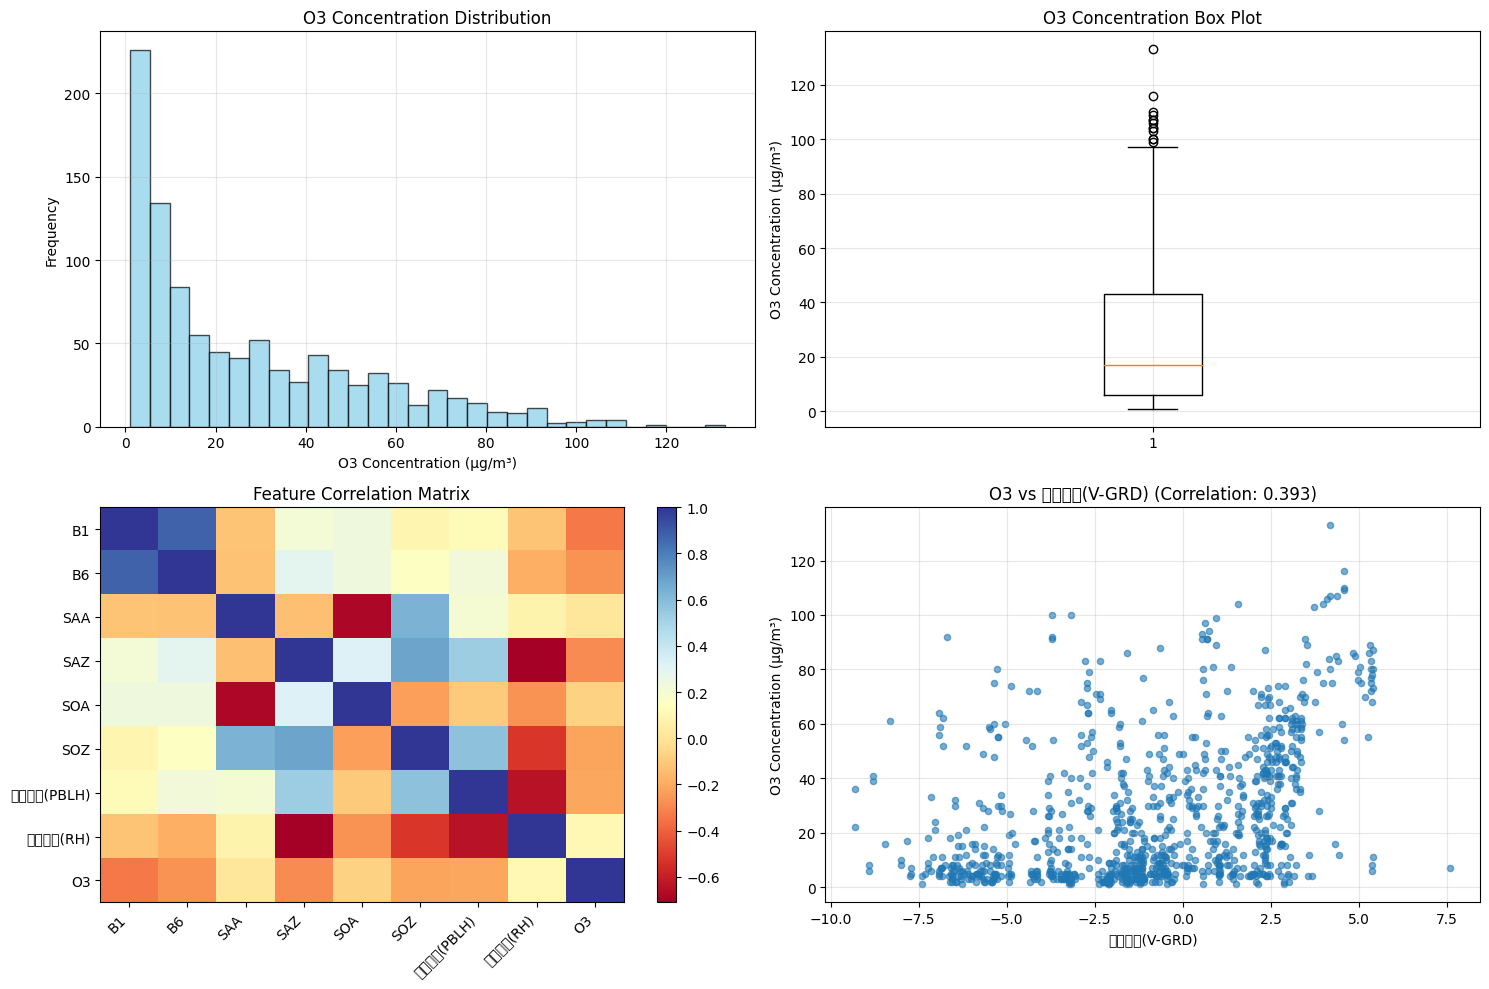

Top 5 features correlated with O3:
垂直风速(V-GRD)    0.392685
B1             0.334964
SAZ            0.283166
B6             0.267470
SOZ            0.221575
dtype: float64


In [7]:
# Cell 5: Data Visualization - O3 Distribution and Feature Correlations
# O3 distribution histogram
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# O3 distribution
axes[0,0].hist(y, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('O3 Concentration Distribution')
axes[0,0].set_xlabel('O3 Concentration (μg/m³)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# O3 box plot
axes[0,1].boxplot(y)
axes[0,1].set_title('O3 Concentration Box Plot')
axes[0,1].set_ylabel('O3 Concentration (μg/m³)')
axes[0,1].grid(True, alpha=0.3)

# Correlation heatmap (subset of features for visibility)
corr_features = feature_cols[:8] if len(feature_cols) > 8 else feature_cols
corr_data = df_clean[corr_features + ['O3']].corr()
im = axes[1,0].imshow(corr_data.values, cmap='RdYlBu', aspect='auto')
axes[1,0].set_xticks(range(len(corr_data.columns)))
axes[1,0].set_yticks(range(len(corr_data.columns)))
axes[1,0].set_xticklabels(corr_data.columns, rotation=45, ha='right')
axes[1,0].set_yticklabels(corr_data.columns)
axes[1,0].set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=axes[1,0])

# Scatter plot: O3 vs most correlated feature
corr_with_o3 = df_clean[feature_cols].corrwith(df_clean['O3']).abs().sort_values(ascending=False)
top_feature = corr_with_o3.index[0]
axes[1,1].scatter(df_clean[top_feature], df_clean['O3'], alpha=0.6, s=20)
axes[1,1].set_xlabel(f'{top_feature}')
axes[1,1].set_ylabel('O3 Concentration (μg/m³)')
axes[1,1].set_title(f'O3 vs {top_feature} (Correlation: {corr_with_o3.iloc[0]:.3f})')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Top 5 features correlated with O3:")
print(corr_with_o3.head())


In [8]:
# Cell 6: Model Definition and Cross-Validation Setup
print("3. Model Definition and 10-Fold Cross-Validation...")

# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)
}

# 10-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Store results
results = {
    'model': [],
    'rmse_scores': [],
    'r2_scores': [],
    'rmse_mean': [],
    'rmse_std': [],
    'r2_mean': [],
    'r2_std': []
}

print("Starting cross-validation...")
print(f"Data size: {X.shape[0]} samples, {X.shape[1]} features")

3. Model Definition and 10-Fold Cross-Validation...
Starting cross-validation...
Data size: 967 samples, 12 features


In [9]:
# Cell 7: Model Training and Cross-Validation
# Train and evaluate models
for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    
    # Store results for each fold
    fold_rmse = []
    fold_r2 = []
    
    fold_num = 1
    for train_idx, val_idx in kf.split(X):
        # Split training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        fold_rmse.append(rmse)
        fold_r2.append(r2)
        
        print(f"  Fold {fold_num}: RMSE={rmse:.3f}, R²={r2:.3f}")
        fold_num += 1
    
    # Calculate mean and standard deviation
    rmse_mean = np.mean(fold_rmse)
    rmse_std = np.std(fold_rmse)
    r2_mean = np.mean(fold_r2)
    r2_std = np.std(fold_r2)
    
    # Store results
    results['model'].append(model_name)
    results['rmse_scores'].append(fold_rmse)
    results['r2_scores'].append(fold_r2)
    results['rmse_mean'].append(rmse_mean)
    results['rmse_std'].append(rmse_std)
    results['r2_mean'].append(r2_mean)
    results['r2_std'].append(r2_std)
    
    print(f"  Average Results: RMSE={rmse_mean:.3f}±{rmse_std:.3f}, R²={r2_mean:.3f}±{r2_std:.3f}")


Training Random Forest model...
  Fold 1: RMSE=17.105, R²=0.576
  Fold 2: RMSE=12.520, R²=0.721
  Fold 3: RMSE=13.463, R²=0.770
  Fold 4: RMSE=11.983, R²=0.709
  Fold 5: RMSE=14.650, R²=0.656
  Fold 6: RMSE=14.862, R²=0.696
  Fold 7: RMSE=15.115, R²=0.664
  Fold 8: RMSE=12.980, R²=0.764
  Fold 9: RMSE=11.445, R²=0.736
  Fold 10: RMSE=11.866, R²=0.787
  Average Results: RMSE=13.599±1.706, R²=0.708±0.060

Training XGBoost model...
  Fold 1: RMSE=17.653, R²=0.548
  Fold 2: RMSE=14.070, R²=0.648
  Fold 3: RMSE=14.860, R²=0.720
  Fold 4: RMSE=12.361, R²=0.691
  Fold 5: RMSE=16.652, R²=0.555
  Fold 6: RMSE=15.082, R²=0.687
  Fold 7: RMSE=14.928, R²=0.673
  Fold 8: RMSE=12.557, R²=0.779
  Fold 9: RMSE=11.380, R²=0.739
  Fold 10: RMSE=13.933, R²=0.706
  Average Results: RMSE=14.348±1.832, R²=0.675±0.070

Training LightGBM model...
  Fold 1: RMSE=17.707, R²=0.545
  Fold 2: RMSE=13.183, R²=0.691
  Fold 3: RMSE=14.028, R²=0.750
  Fold 4: RMSE=12.819, R²=0.667
  Fold 5: RMSE=15.727, R²=0.603
  Fo

In [10]:
# Cell 8: Results Summary and Analysis
print("\n" + "="*60)
print("Cross-Validation Results Summary")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame({
    'Model': results['model'],
    'RMSE_Mean': results['rmse_mean'],
    'RMSE_Std': results['rmse_std'],
    'R²_Mean': results['r2_mean'],
    'R²_Std': results['r2_std']
})

print("\nDetailed Results Table:")
print(results_df.round(4))

# Find best models
best_rmse_idx = np.argmin(results['rmse_mean'])
best_r2_idx = np.argmax(results['r2_mean'])

print(f"\nBest Model (Lowest RMSE): {results['model'][best_rmse_idx]} (RMSE: {results['rmse_mean'][best_rmse_idx]:.3f})")
print(f"Best Model (Highest R²): {results['model'][best_r2_idx]} (R²: {results['r2_mean'][best_r2_idx]:.3f})")

# Statistical significance test (simple comparison)
print(f"\nModel Performance Ranking (by R²):")
sorted_indices = np.argsort(results['r2_mean'])[::-1]
for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. {results['model'][idx]}: R²={results['r2_mean'][idx]:.3f}±{results['r2_std'][idx]:.3f}")


Cross-Validation Results Summary

Detailed Results Table:
           Model  RMSE_Mean  RMSE_Std  R²_Mean  R²_Std
0  Random Forest    13.5989    1.7060   0.7079  0.0603
1        XGBoost    14.3477    1.8324   0.6745  0.0703
2       LightGBM    13.9323    1.8704   0.6920  0.0728

Best Model (Lowest RMSE): Random Forest (RMSE: 13.599)
Best Model (Highest R²): Random Forest (R²: 0.708)

Model Performance Ranking (by R²):
1. Random Forest: R²=0.708±0.060
2. LightGBM: R²=0.692±0.073
3. XGBoost: R²=0.675±0.070


4. Results Visualization...


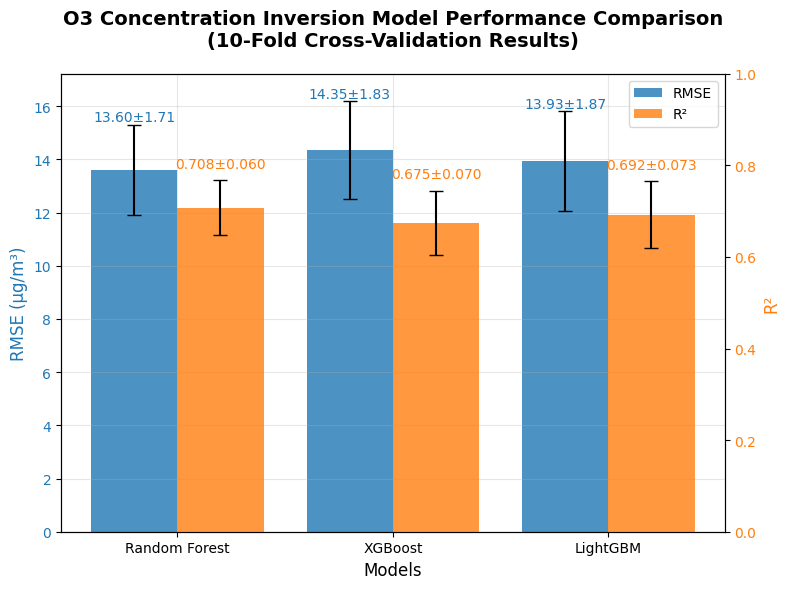

In [24]:
# Cell 9: Results Visualization - Dual-Axis Bar Chart
print("4. Results Visualization...")

import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(8, 6)) 

models_names = results['model']
x_pos = np.arange(len(models_names))

ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('RMSE (μg/m³)', color='#1f77b4', fontsize=12)
bars1 = ax1.bar([x - 0.2 for x in x_pos], results['rmse_mean'], 
               yerr=results['rmse_std'], width=0.4, 
               color='#1f77b4', alpha=0.8, capsize=5,
               label='RMSE')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_ylim(0, max(results['rmse_mean']) * 1.2)

for i, (bar, mean_val, std_val) in enumerate(zip(bars1, results['rmse_mean'], results['rmse_std'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.01,
             f'{mean_val:.2f}±{std_val:.2f}',
             ha='center', va='bottom', fontsize=10, color='#1f77b4')

ax2 = ax1.twinx()
ax2.set_ylabel('R²', color='#ff7f0e', fontsize=12)
bars2 = ax2.bar([x + 0.2 for x in x_pos], results['r2_mean'], 
               yerr=results['r2_std'], width=0.4, 
               color='#ff7f0e', alpha=0.8, capsize=5,
               label='R²')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax2.set_ylim(0, 1)

for i, (bar, mean_val, std_val) in enumerate(zip(bars2, results['r2_mean'], results['r2_std'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std_val + 0.02,
             f'{mean_val:.3f}±{std_val:.3f}',
             ha='center', va='bottom', fontsize=10, color='#ff7f0e')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names)

plt.title('O3 Concentration Inversion Model Performance Comparison\n(10-Fold Cross-Validation Results)', 
          fontsize=14, fontweight='bold', pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


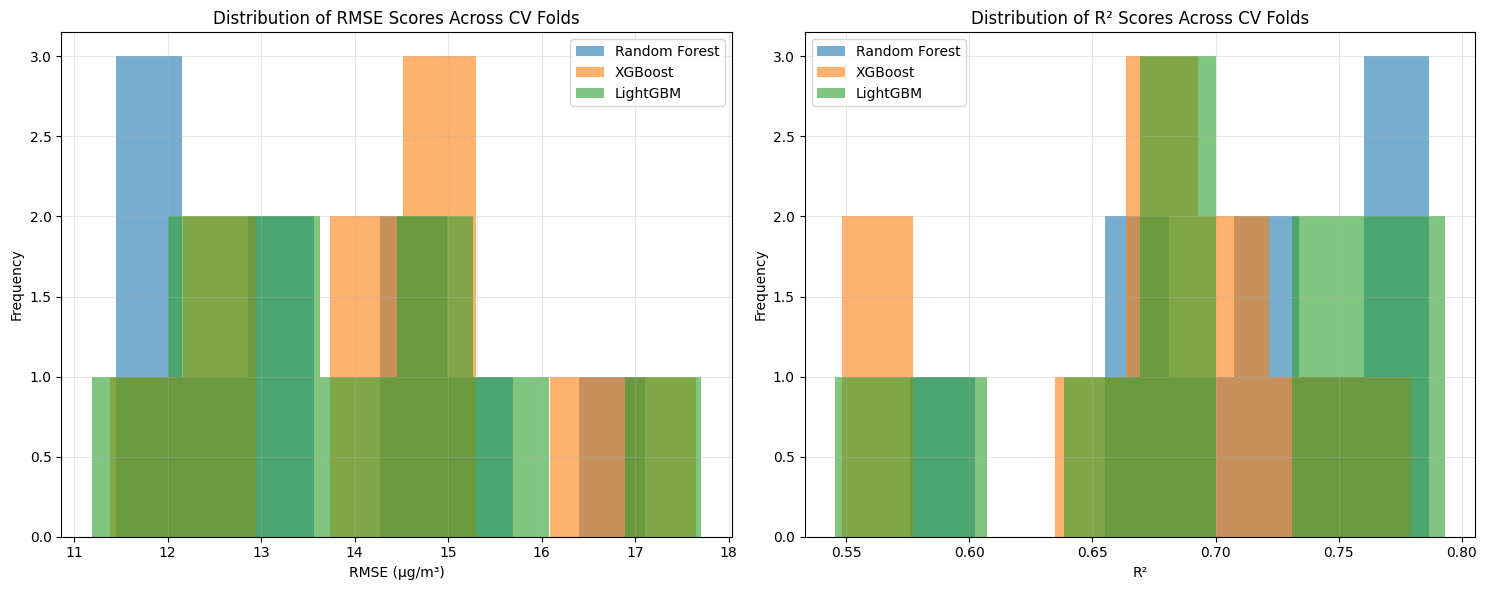

In [25]:
# Cell 10: Cross-Validation Scores Distribution
# Visualization of CV score distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RMSE distribution
for i, model_name in enumerate(results['model']):
    axes[0].hist(results['rmse_scores'][i], alpha=0.6, label=model_name, bins=8)
axes[0].set_xlabel('RMSE (μg/m³)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of RMSE Scores Across CV Folds')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# R² distribution
for i, model_name in enumerate(results['model']):
    axes[1].hist(results['r2_scores'][i], alpha=0.6, label=model_name, bins=8)
axes[1].set_xlabel('R²')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of R² Scores Across CV Folds')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


5. Feature Importance Analysis...

Random Forest Model Feature Importance Ranking:
        Feature  Importance
11  垂直风速(V-GRD)      0.2079
3           SAZ      0.1972
5           SOZ      0.1121
2           SAA      0.0805
6    边界层高(PBLH)      0.0700
9     大气温度(TMP)      0.0692
4           SOA      0.0680
8      气压(PRES)      0.0437
7      相对湿度(RH)      0.0428
10  水平风速(U-GRD)      0.0397
0            B1      0.0354
1            B6      0.0335


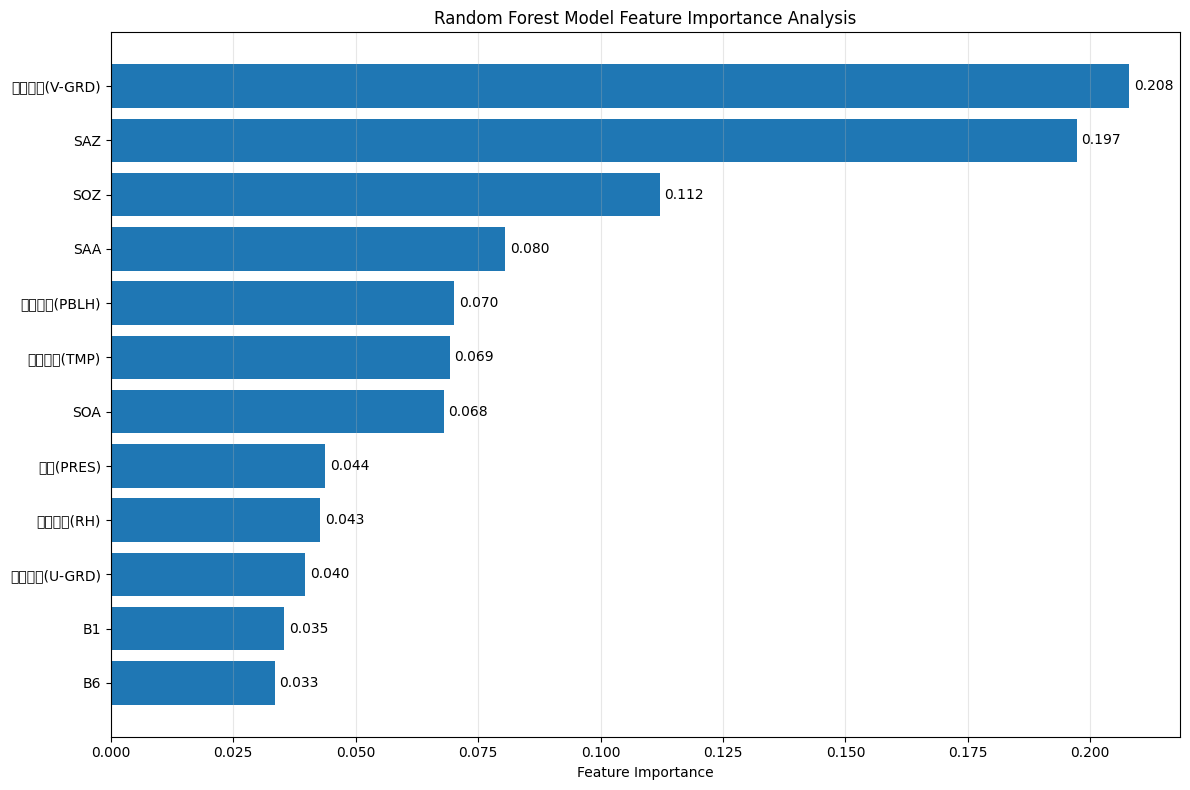

In [26]:
# Cell 11: Feature Importance Analysis
print("5. Feature Importance Analysis...")

# Use the best model for feature importance analysis
best_model_name = results['model'][best_r2_idx]
if best_model_name == 'Random Forest':
    best_model = RandomForestRegressor(n_estimators=100, random_state=42)
elif best_model_name == 'XGBoost':
    best_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
else:  # LightGBM
    best_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)

# Train the best model on full data
best_model.fit(X, y)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(f"\n{best_model_name} Model Feature Importance Ranking:")
    print(importance_df.round(4))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(importance_df)), importance_df['Importance'])
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'{best_model_name} Model Feature Importance Analysis')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(importance_df['Importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

6. Model Validation Visualization...


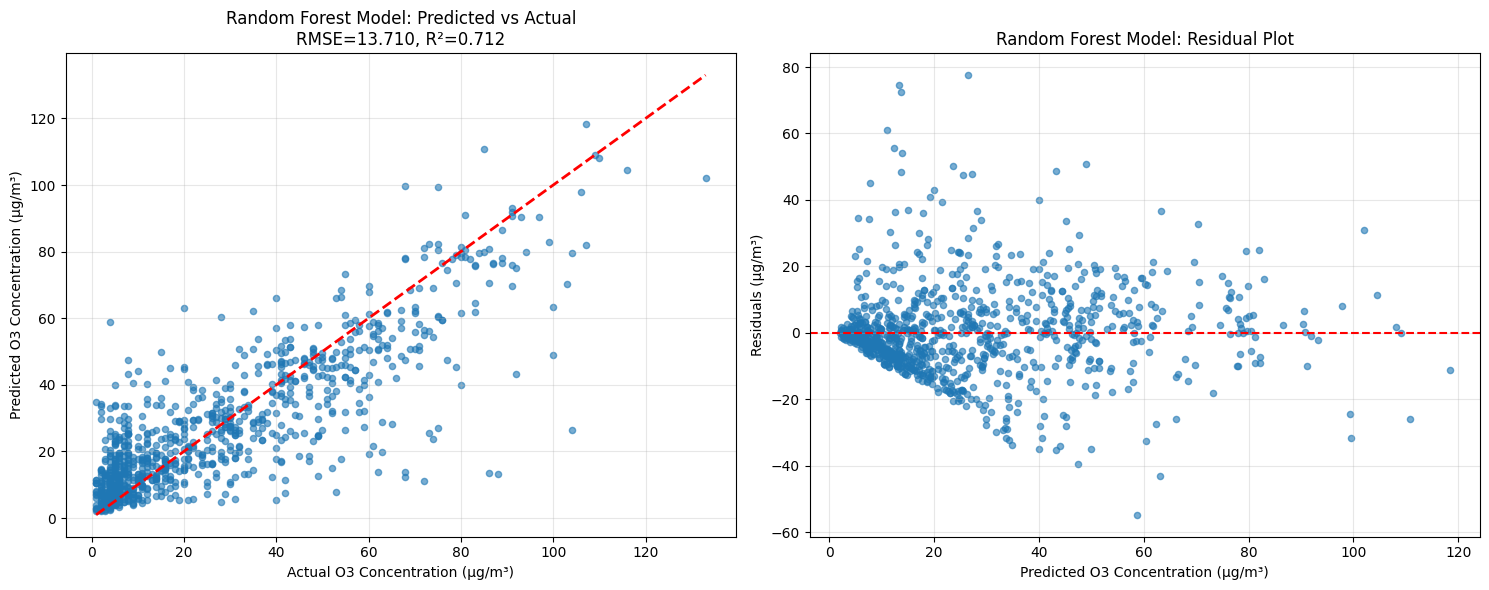

In [27]:
# Cell 12: Model Validation and Prediction Visualization
# Create prediction vs actual plots for the best model
print("6. Model Validation Visualization...")

# Get predictions using cross-validation for fair comparison
from sklearn.model_selection import cross_val_predict

best_model_fresh = None
if best_model_name == 'Random Forest':
    best_model_fresh = RandomForestRegressor(n_estimators=100, random_state=42)
elif best_model_name == 'XGBoost':
    best_model_fresh = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
else:  # LightGBM
    best_model_fresh = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbosity=-1)

# Get cross-validated predictions
y_pred_cv = cross_val_predict(best_model_fresh, X, y, cv=kf)

# Calculate overall metrics
overall_rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
overall_r2 = r2_score(y, y_pred_cv)

# Create prediction plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Predicted vs Actual
axes[0].scatter(y, y_pred_cv, alpha=0.6, s=20)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual O3 Concentration (μg/m³)')
axes[0].set_ylabel('Predicted O3 Concentration (μg/m³)')
axes[0].set_title(f'{best_model_name} Model: Predicted vs Actual\nRMSE={overall_rmse:.3f}, R²={overall_r2:.3f}')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y - y_pred_cv
axes[1].scatter(y_pred_cv, residuals, alpha=0.6, s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted O3 Concentration (μg/m³)')
axes[1].set_ylabel('Residuals (μg/m³)')
axes[1].set_title(f'{best_model_name} Model: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Cell 13: Final Summary and Recommendations
print("\n" + "="*60)
print("O3 Concentration Inversion Model Construction Complete!")
print("="*60)

print(f"\nModel Performance Summary:")
for i, model_name in enumerate(results['model']):
    print(f"{model_name:15}: RMSE={results['rmse_mean'][i]:.3f}±{results['rmse_std'][i]:.3f}, "
          f"R²={results['r2_mean'][i]:.3f}±{results['r2_std'][i]:.3f}")

print(f"\nRecommended Model: {best_model_name} (R²={results['r2_mean'][best_r2_idx]:.3f})")

print(f"\nTop 3 Important Features for O3 Prediction:")
for i in range(min(3, len(importance_df))):
    feature = importance_df.iloc[i]['Feature']
    importance = importance_df.iloc[i]['Importance']
    print(f"  {i+1}. {feature}: {importance:.3f}")

print(f"\nModel Interpretation:")
print(f"- The {best_model_name} model achieves an R² of {results['r2_mean'][best_r2_idx]:.3f}, ")
print(f"  explaining {results['r2_mean'][best_r2_idx]*100:.1f}% of the variance in O3 concentrations.")
print(f"- RMSE of {results['rmse_mean'][best_r2_idx]:.3f} μg/m³ indicates good prediction accuracy.")
print(f"- This model can be used for O3 concentration prediction based on")
print(f"  satellite remote sensing and meteorological data.")

print(f"\nApplications:")
print(f"- Real-time O3 concentration monitoring")
print(f"- Air quality forecasting")
print(f"- Environmental impact assessment")
print(f"- Policy support for air pollution control")


O3 Concentration Inversion Model Construction Complete!

Model Performance Summary:
Random Forest  : RMSE=13.599±1.706, R²=0.708±0.060
XGBoost        : RMSE=14.348±1.832, R²=0.675±0.070
LightGBM       : RMSE=13.932±1.870, R²=0.692±0.073

Recommended Model: Random Forest (R²=0.708)

Top 3 Important Features for O3 Prediction:
  1. 垂直风速(V-GRD): 0.208
  2. SAZ: 0.197
  3. SOZ: 0.112

Model Interpretation:
- The Random Forest model achieves an R² of 0.708, 
  explaining 70.8% of the variance in O3 concentrations.
- RMSE of 13.599 μg/m³ indicates good prediction accuracy.
- This model can be used for O3 concentration prediction based on
  satellite remote sensing and meteorological data.

Applications:
- Real-time O3 concentration monitoring
- Air quality forecasting
- Environmental impact assessment
- Policy support for air pollution control
